# Subdomains tutorial

This tutorial is designed to introduce users to the concept of subdomains in Devito and how to utilize them within simulations for a variety of purposes.

We will begin by exploring the subdomains created internally (and by default) when creating a `Grid` and then explore in detail how users can define and utilize their own subdomains.

Consider the construction of the following `Grid`:

In [1]:
from devito import Grid
shape = (10, 10, 10)
grid = Grid(shape=shape, extent=shape)

Looking at the `subdomains` property we see:

In [2]:
grid.subdomains

{'domain': Domain[domain(x, y, z)],
 'interior': Interior[interior(i0x, i0y, i0z)]}

With the creation of `Grid` two subdomains have been generated by default, 'domain' and 'interior'. We will shortly explore how such subdomains are defined, but before continuing let us explore some of their properties a little further.

First, looking at the following:

In [3]:
grid.subdomains['domain']

Domain[domain(x, y, z)]

In [4]:
grid.subdomains['domain'].shape

(10, 10, 10)

we see that 'domain' is in fact the entire computational domain. We can check that it has the same dimensions as grid:

In [5]:
grid.subdomains['domain'].dimensions == grid.dimensions

True

However, when we look at the 'interior' subdomain we see:

In [6]:
grid.subdomains['interior']

Interior[interior(i0x, i0y, i0z)]

In [7]:
grid.subdomains['interior'].shape

(8, 8, 8)

In [8]:
grid.subdomains['interior'].dimensions == grid.dimensions

False

This subdomain is in fact defined to be the computational grid excluding the 'outermost' grid point in each dimension, hence the shape `(8, 8, 8)`.

The above two subdomains are initialised upon creation of a grid for various internal reasons and users, generally, need not concern themselves with their existence. However, users will often wish to specify their own subdomains to, e.g., specify different physical equations on different parts of a grid. Before returning to an example of the latter, and to familiarise ourselves with the basics, let us dive into an example of how a user could 'explicitly' create subdomains such as 'domain' and 'interior' themselves.

## The `SubDomain` class

To make use of subdomains we first import the `SubDomain` class:

In [9]:
from devito import SubDomain

Here is an example of how to define a subdomain that spans an entire 3D computational grid (this is similar to how 'domain' is defined internally):

In [10]:
class FullDomain(SubDomain):
    name = 'mydomain'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: z}

In the above snippet, we have defined a class `FullDomain` based on `SubDomain` with the method `define` overridden. This method takes as input a set of Dimensions and produces a mapper from which we can create a subdomain. It is through utilizing this mapper that various types of subdomains can be created. The mapper `{x: x, y: y, z: z}` is simply saying that we wish for the three dimensions of our subdomain be exactly the input dimensions `x, y, z`. Note that for a 2D domain we would need to remove one of the dimensions, i.e. `{x: x, y: y}`, or more generally for an N-dimensional domain one could write `{d: d for d in dimensions}`.

Now, lets us compose a subdomain from our class `FullDomain`:

In [11]:
full_domain = FullDomain()

It is important to note that whilst the `full_domain` object has now been initialised, it has not yet been finalised, i.e. it is not currently associated with any grid. To attach this subdomain to a grid we must pass it to the grid during its creation (the subdomain will then be finalised during creation of the grid):

In [12]:
my_grid = Grid(shape = (10, 10, 10), subdomains = (full_domain, ))

If we look at the subdomains of `my_grid` we see that our new subdomain 'mydomain' is now present:

In [13]:
my_grid.subdomains

{'domain': Domain[domain(x, y, z)],
 'interior': Interior[interior(i0x, i0y, i0z)],
 'mydomain': FullDomain[mydomain(x, y, z)]}

As expected (and intended), the dimensions of our newly defined subdomain match those of 'domain'.

Now, let us create a subdomain consisting of all but the outer grid point in each dimension (similar to 'interior'):

In [14]:
class InnerDomain(SubDomain):
    name = 'inner'
    def define(self, dimensions):
        d = dimensions
        return {d: ('middle', 1, 1) for d in dimensions}

First, note that in the above we have used the shortand `d = dimensions` so that `d` will be a tuple of N-dimensions and then `{d: ... for d in dimensions}` such that our mapper will be valid for N-dimensional grids. Next we note the inclusion of `('middle', 1, 1)`. For mappers of the form `('middle', N, M)`, the `SubDomain` spans a contiguous region of `dimension_size - (N + M)` points starting at (in terms of python indexing) `N` and finishing at ``dimension_size - M - 1``.

The two other options available are `'left'` and `'right'`. For a statement of the form `d: ('left', N)` the `SubDomain` spans a contiguous region of `N` points starting at `d`\'s left extreme. A statement of the form `('right', N)` is analogous to the previous case but starting at the dimensions right extreme instead.

Now, to create a grid containing both of the subdomains defined above, 'mydomain' and 'inner', we simply pass these during the creation of a grid:

In [15]:
inner_domain = InnerDomain()
my_grid = Grid(shape = (10, 10, 10), subdomains = (full_domain, inner_domain))

If our subdomain `'inner'` is defined correctly we would expect it have a shape of `(8, 8, 8)`.

In [16]:
my_grid.subdomains['inner'].shape

(8, 8, 8)

This is indeed the case.

Now, let us look at some simple examples of how to define subdomains using 'middle', 'left' and 'right' and then utilize these in an operator.

The first subdomain we define will consist of the computational grid excluding, in the `x` dimension 3 nodes on the right and 4 on the left and in the `y` dimension, 4 nodes on the left and 3 on the right:

In [17]:
class Middle(SubDomain):
    name = 'middle'
    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 3, 4), y: ('middle', 4, 3)}
mid = Middle()

Now, let us form an equation and evaluate it only on the subdomain 'middle'. To do this we first import some required objects from Devito:

In [18]:
from devito import Function, Eq, Operator

We then create our grid containing the subdomain 'middle' and when forming our equation pass this subdomain to the equation, thus telling Devito to only evaluate that particular equation within the subdomain 'middle':

In [19]:
#NBVAL_IGNORE_OUTPUT
grid = Grid(shape = (10, 10), subdomains = (mid, ))
f = Function(name = 'f', grid = grid)

eq = Eq(f, f+1, subdomain = grid.subdomains['middle'])

op = Operator(eq)()

Operator `Kernel` ran in 0.01 s


The result we expect is that our function `f`'s data should have a values of `1` within the subdomain and `0` elsewhere. Viewing `f`'s data we see this is indeed the case:

In [20]:
f.data

Data([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

We now create some additional subdomains utilising `'left'` and `'right'`. The first domain named 'left' will consist of two nodes on the left hand side in the `x` dimension and the entire of the `y` dimension:

In [21]:
class Left(SubDomain):
    name = 'left'
    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 2), y: y}
ld = Left()

Next, our subdomain named 'right' will consist of the entire `x` dimension and the two 'right-most' nodes in the `y` dimension:

In [22]:
class Right(SubDomain):
    name = 'right'
    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('right', 2)}
rd = Right()

Note that owing to the chosen definitions of 'left' and 'right' there will be four grid points on which these two subdomains overlap.

Then, let us create a grid consisting of the subdomains 'middle', 'left' and 'right' and specify an equation on each of the three subdomains:

In [23]:
grid = Grid(shape = (10, 10), subdomains = (mid, ld, rd))
f = Function(name = 'f', grid = grid)

eq1 = Eq(f, f+1, subdomain = grid.subdomains['middle'])
eq2 = Eq(f, f+2, subdomain = grid.subdomains['left'])
eq3 = Eq(f, f+3, subdomain = grid.subdomains['right'])

We then create and execute an operator that evaluates the above equations:

In [24]:
#NBVAL_IGNORE_OUTPUT
op2 = Operator([eq1, eq2, eq3])()

Operator `Kernel` ran in 0.01 s


Viewing the data of `f` after performing the operation we see that:

In [25]:
f.data

Data([[2., 2., 2., 2., 2., 2., 2., 2., 5., 5.],
      [2., 2., 2., 2., 2., 2., 2., 2., 5., 5.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.]], dtype=float32)

## Seismic wave propagation example with subdomains

We will now utilise subdomains in a seismic wave-propagation model. Subdomains are used here to specify different equations in two sections of the domain. Our model will consist of an upper water section and a lower rock section consisting of two distinct layers of rock. In this example the elastic wave-equation will be solved, however in the water section, since the Lame constant (`mu`) is zero (and hence the equations can be reduced to the acoustic wave-equations), terms containing `mu` will be removed.

It is useful to review seismic tutorial numbers 6 (elastic setup) to understand the seismic based utilities used below (since here they will simply be 'used' with little explanation).

We first import all required modules:

In [26]:
import numpy as np
from devito import (TimeFunction, VectorTimeFunction, TensorTimeFunction,
                    div, grad, curl, diag)
from examples.seismic import ModelElastic, plot_velocity, TimeAxis, RickerSource, plot_image

We now define the problem dimensions and velocity model:

In [27]:
extent = (200., 100., 100.) # 200 x 100 x 100 m domain
h = 1.0 # Desired grid spacing
# Set the grid to have a shape (201, 101, 101) for h=1:
shape = (int(extent[0]/h+1), int(extent[1]/h+1), int(extent[2]/h+1))

# Model physical parameters:
vp = np.zeros(shape)
vs = np.zeros(shape)
rho = np.zeros(shape)

# Set up three horizontally separated layers:
l1 = int(0.5*shape[2])+1 # End of the water layer at 50m depth
l2 = int(0.5*shape[2])+1+int(4/h) # End of the soft rock section at 54m depth

# Water layer model
vp[:,:,:l1] = 1.52
vs[:,:,:l1] = 0.
rho[:,:,:l1] = 1.05

# Soft-rock layer model
vp[:,:,l1:l2] = 1.6
vs[:,:,l1:l2] = 0.4
rho[:,:,l1:l2] = 1.3

# Hard-rock layer model
vp[:,:,l2:] = 2.2
vs[:,:,l2:] = 1.2
rho[:,:,l2:] = 2.

origin = (0, 0, 0)
spacing = (h, h, h)

Before defining and creating our subdomains we define the thickness of our absorption layer:

In [28]:
nbl = 20 # Number of absorbing boundary layers cells

Now define our subdomains, one for the upper water layer, and one for the rock layers beneath:

In [29]:
# Define our 'upper' and 'lower' SubDomains:
class Upper(SubDomain):
    name = 'upper'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: ('left', l1+nbl)}
    
class Lower(SubDomain):
    name = 'lower'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: ('right', shape[2]+nbl-l1)}

# Create these subdomains:
ur = Upper()
lr = Lower()

Create our model to which we pass the subdomains `ur` and `lr`. Within model they will then be used when creating the model grid:

In [30]:
#NBVAL_IGNORE_OUTPUT
so = 4 # FD space order (Note that the time order is by default 1).

model = ModelElastic(space_order=so, vp=vp, vs=vs, b=1/rho, origin=origin, shape=shape,
                     spacing=spacing, nbl=nbl, subdomains=(ur,lr))

Operator `initdamp` ran in 0.02 s
Operator `pad_lam` ran in 0.02 s
Operator `pad_mu` ran in 0.02 s
Operator `pad_b` ran in 0.01 s


Now prepare model parameters along with the functions to be used in the PDE, and the source injection term:

In [31]:
s = model.grid.stepping_dim.spacing

# Source freq. in MHz (note that the source is defined below):
f0 = 0.12

# Thorbecke's parameter notation
l = model.lam
mu = model.mu
ro = model.b

t0, tn = 0., 30.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# PDE functions:
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

# Source
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
src.coordinates.data[:] = np.array([100., 50., 35.])

# The source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*s)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*s)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*s)

We now define the model equations. Sets of equations will be defined on each subdomain, 'upper' and 'lower', to which we pass the subdomain object when creating the equation:

In [32]:
u_v_u = Eq(v.forward, model.damp * (v + s*ro*div(tau)), subdomain = model.grid.subdomains['upper'])
u_t_u = Eq(tau.forward, model.damp * (tau + s * l * diag(div(v.forward))),
           subdomain = model.grid.subdomains['upper'])

u_v_l = Eq(v.forward, model.damp * (v + s*ro*div(tau)), subdomain = model.grid.subdomains['lower'])
u_t_l = Eq(tau.forward, model.damp * (tau + s * l * diag(div(v.forward))
                                      + s * mu * (grad(v.forward) + grad(v.forward).T)),
           subdomain = model.grid.subdomains['lower'])

We can now create and run an operator:

In [33]:
#NBVAL_IGNORE_OUTPUT
op = Operator([u_v_u, u_v_l, u_t_u, u_t_l] + src_xx + src_yy + src_zz, subs=model.spacing_map)
op(dt=dt)

Operator `Kernel` ran in 13.59 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=13.584479000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0003199999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Finally, plot some results:

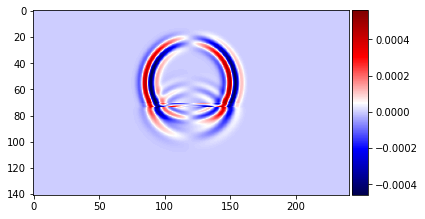

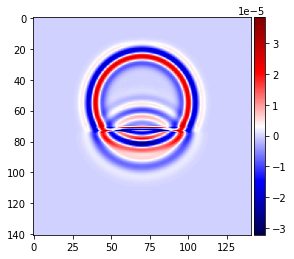

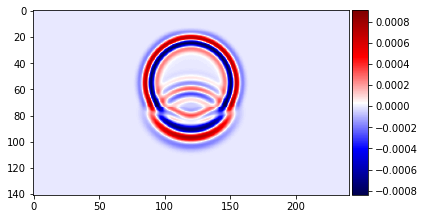

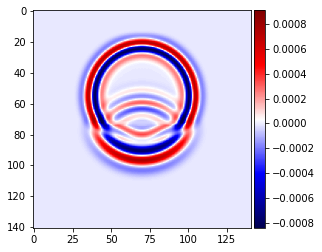

In [34]:
#NBVAL_IGNORE_OUTPUT

# Plots
%matplotlib inline

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

## Note:

When creating a grid with many subdomains the process introduced in this notebook becomes cumbersome. For such cases the `SubDomainSet` object is available allowing users to easily define a large number of subdomains. A tutorial regarding the use of `SubDomainSet`'s will be released at some point in the future.